In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.optimize import basinhopping
import scipy
import patsy
import os.path as op
import glob
import functools
import moss
import multiprocessing
%matplotlib inline

### Table of Contents

* [Simple RT](#rt)
    * [RT By Gene](#rtgene)
    * [RT By PET](#rtpet)
* [Salience Attribution](#salience)
    * [RT by reward state](#saliencert)
        * [Salience by Gene](#saliencertgene)
        * [Salience by PET](#saliencertpet)
    * [Explicit Reports by reward state](#salienceguess)
        * [Salience by Gene](#salienceguessgene)
        * [Salience by PET](#salienceguesspet)
* [Trial-by-trial Analyses](#modelfree)
    * [Bromocriptine effect on learning from omissions](#bromoomissions)
    * [Bromocriptine effect on guesses](#bromoomissionsguess)
* [Reaction time variability](#rtvariability)

In [55]:
home_dir = op.abspath('./')
df = pd.read_csv(op.abspath('./dataframes/rts.csv'))
baseline = pd.read_csv(op.abspath('./dataframes/baseline_rts.csv'))
pet_df = pd.read_csv(op.abspath('./dataframes/pet.csv'))

df = pd.merge(pet_df,df, how = 'outer', on = ['sub'])

subs = list(set(df['sub']))
len(subs)

77

In [56]:
df.head()

,Unnamed: 0_x,L_caud_body_mean_rac,L_DCA_mean_rac,L_DPUT_mean_rac,L_VST_mean_rac,R_caud_body_mean_rac,R_DCA_mean_rac,R_DPUT_mean_rac,R_VST_mean_rac,sub,...,FB_last_trial,transition_type,rew_last_trial,rew_2_trials_back,rew_3_trials_back,rew_last_trial_bin,rew_2_trials_back_bin,rew_3_trials_back_bin,too_early_last_trial,rew_rate
0,0.0,2.710008,3.354507,3.999494,2.610669,2.81783,3.288887,4.037211,2.620591,7,...,NaN,NaN,NaN,NaN,NaN,0,0,0,False,NaN
1,0.0,2.710008,3.354507,3.999494,2.610669,2.81783,3.288887,4.037211,2.620591,7,...,Quick - very good:,SameFeature,0.07,NaN,NaN,1,0,0,False,NaN
2,0.0,2.710008,3.354507,3.999494,2.610669,2.81783,3.288887,4.037211,2.620591,7,...,Quick - very good:,SameFeature,0.06,0.07,NaN,1,1,0,False,NaN
3,0.0,2.710008,3.354507,3.999494,2.610669,2.81783,3.288887,4.037211,2.620591,7,...,NaN,SameFeature,0.00,0.06,0.07,0,1,1,False,2.0
4,0.0,2.710008,3.354507,3.999494,2.610669,2.81783,3.288887,4.037211,2.620591,7,...,NaN,SameStim,0.00,0.00,0.06,0,0,1,False,1.0


In [57]:
df.groupby(['sub']).mean().dropna(subset = ['AMY_rac2']).shape


(52, 75)

# Simple RT  <a name="rt"></a>

Both drugs significantly slow reaction times

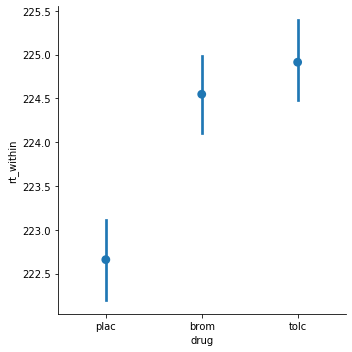

In [59]:
sns.catplot(x = 'drug',
           y = 'rt_within',
           unit = 'sub',
            order = ['plac','brom','tolc'],
#             hue = 'block',
#               col = 'DRD2',
            join = False,
            ci = 68,
           data = df,
           kind = 'point')
plt.savefig('./figs/simple_rt.png', dpi = 300)

## Simple RT by drug and gene <a name="rtgene"></a>

Met’s and A1- are slower on average. Odd COMT X Bromo interaction (trending COMT X tolc). No other significant interactions.

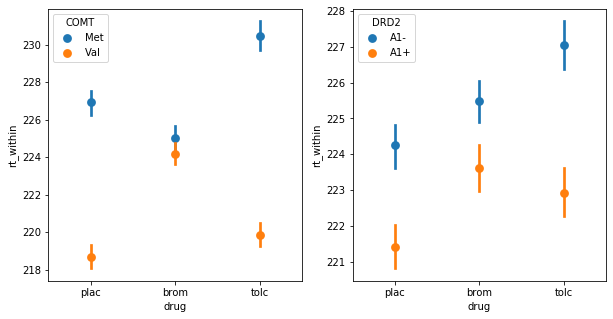

In [62]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
for n, gene in enumerate(['COMT','DRD2']):
    sns.pointplot(x = 'drug',
               y = 'rt_within',
                  order = ['plac','brom','tolc'],
               unit = 'sub',
                hue = gene,
                join = False,
                ci = 68,
               data = df,
               ax = ax[n])
plt.savefig('./figs/simple_rt_gene.png', dpi = 300)

In [87]:
df_model = df.dropna(subset = ['rt'])

md = smf.mixedlm("rt ~ C(drug,  Treatment(reference='plac'))*C(DRD2,Sum)", df_model, groups=df_model['sub']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                    Mixed Linear Model Regression Results
==============================================================================================================
Model:                              MixedLM                  Dependent Variable:                  rt          
No. Observations:                   28980                    Method:                              REML        
No. Groups:                         77                       Scale:                               1936.1133   
Min. group size:                    250                      Log-Likelihood:                      -150951.9920
Max. group size:                    639                      Converged:                           Yes         
Mean group size:                    376.4                                                                     
--------------------------------------------------------------------------------------------------------------
                                                                  Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                                        222.451    2.479 89.750 0.000 217.593 227.309
C(drug, Treatment(reference='plac'))[T.brom]                       1.954    0.637  3.068 0.002   0.706   3.202
C(drug, Treatment(reference='plac'))[T.tolc]                       2.246    0.649  3.461 0.001   0.974   3.517
C(DRD2, Sum)[S.A1+]                                               -1.462    2.479 -0.590 0.555  -6.320   3.396
C(drug, Treatment(reference='plac'))[T.brom]:C(DRD2, Sum)[S.A1+]   0.493    0.637  0.775 0.438  -0.755   1.742
C(drug, Treatment(reference='plac'))[T.tolc]:C(DRD2, Sum)[S.A1+]  -0.512    0.649 -0.790 0.430  -1.784   0.759
Group Var                                                        455.742    1.713                             
==============================================================================================================

"""

In [88]:
df_model = df.dropna(subset = ['rt'])

md = smf.mixedlm("rt ~ C(drug,  Treatment(reference='plac'))*C(COMT,Sum)", df_model, groups=df_model['sub']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                    Mixed Linear Model Regression Results
==============================================================================================================
Model:                              MixedLM                  Dependent Variable:                  rt          
No. Observations:                   28980                    Method:                              REML        
No. Groups:                         77                       Scale:                               1932.0410   
Min. group size:                    250                      Log-Likelihood:                      -150920.7003
Max. group size:                    639                      Converged:                           Yes         
Mean group size:                    376.4                                                                     
--------------------------------------------------------------------------------------------------------------
                                                                  Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                                        222.573    2.447 90.951 0.000 217.777 227.369
C(drug, Treatment(reference='plac'))[T.brom]                       1.704    0.637  2.677 0.007   0.456   2.952
C(drug, Treatment(reference='plac'))[T.tolc]                       2.259    0.648  3.487 0.000   0.989   3.529
C(COMT, Sum)[S.Met]                                                4.684    2.447  1.914 0.056  -0.112   9.480
C(drug, Treatment(reference='plac'))[T.brom]:C(COMT, Sum)[S.Met]  -3.754    0.637 -5.896 0.000  -5.002  -2.506
C(drug, Treatment(reference='plac'))[T.tolc]:C(COMT, Sum)[S.Met]   1.166    0.648  1.800 0.072  -0.104   2.436
Group Var                                                        445.203    1.676                             
==============================================================================================================

"""

## Simple RT by drug and PET <a name="rtpet"></a>

Dorsal caudate raclopride by tolcapone interaction (more D2/3 density is associated with faster responding on tolcapone)

Amygdala raclopride by tolcapone and bromocriptine interaction (more D2/3 density is associated with faster responding on both drugs)

Dorsal caudate Ventral Striatum dopamine sythesis capacity interaction with tolcapone (more synthesis is asdsociated with slower responding on tolcapone)

Dorsal Putamen has a copmplex story: opposite signed interactions between D2/D3 and drug (more D2/D3 means slower responding on bromocriptine but faster on tolcapone). More dopamine synthesis means slower responding on both drugs

None interact with RT at placebo

In [73]:
df_model = df.reset_index().dropna(subset = ['rt','L_DCA_mean_fmt','R_VST_mean_rac'])

pet_measures = ['DCA_rac','VST_rac','AMY_rac','DCA_fmt','VST_fmt','DPUT_rac','DPUT_fmt']
for pet in pet_measures:
    
    df_model[pet] = scipy.stats.zscore(df_model[pet])
    
    md = smf.mixedlm("rt ~ C(drug,  Treatment(reference='plac'))*" + pet, 
                     df_model, groups=df_model['sub']).fit()
    print(pet)
    print(md.summary())
    print('\n\n\n')

DCA_rac
                              Mixed Linear Model Regression Results
Model:                          MixedLM              Dependent Variable:              rt          
No. Observations:               19435                Method:                          REML        
No. Groups:                     52                   Scale:                           2048.2353   
Min. group size:                250                  Log-Likelihood:                  -101780.9200
Max. group size:                617                  Converged:                       Yes         
Mean group size:                373.8                                                             
--------------------------------------------------------------------------------------------------
                                                      Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------------------------------
Intercept                        

DPUT_rac
                               Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              rt          
No. Observations:                19435                Method:                          REML        
No. Groups:                      52                   Scale:                           2044.5259   
Min. group size:                 250                  Log-Likelihood:                  -101763.5631
Max. group size:                 617                  Converged:                       Yes         
Mean group size:                 373.8                                                             
---------------------------------------------------------------------------------------------------
                                                       Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------------------------------
Intercept             

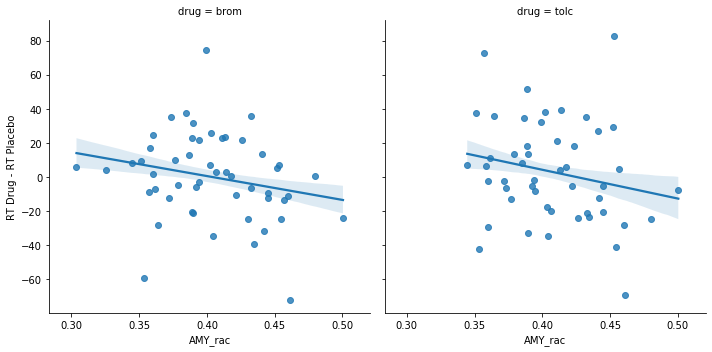

In [74]:
#Visualization of Drug X PET interactions

fig_df = df.groupby(['sub','drug','DRD2','COMT']).mean().reset_index().set_index(['sub','drug'])
for sub, drug in set(fig_df.index):
    fig_df.loc[(sub, drug), 'RT Drug - RT Placebo'] = fig_df.loc[(sub, drug), 'rt'] - fig_df.loc[(sub, 
                                                                            'plac'), 'rt']

fig_df = fig_df.reset_index()

fig_df = fig_df[fig_df.drug != 'plac']
sns.lmplot(x = 'AMY_rac',
           y = 'RT Drug - RT Placebo',
              col = 'drug',
            ci = 68,
           data = fig_df)
plt.savefig('./figs/simple_rt.png')

# Salience Attribution  <a name="salience"></a>

## Salience attribution reaction times <a name="saliencert"></a>

In [95]:
## Get a dataframe with the salience difference effect for ease of visualization

mean_df = df.groupby(['sub','drug','block','salience','DRD2','COMT']).mean()
mean_df = mean_df.reset_index().set_index(['sub','drug','block']).sort_index()
results = []
for sub, drug, block in set(mean_df.index):
    a = mean_df.loc[(sub, drug, block)]
    a = a.reset_index().set_index('salience')
    rt_diff = a.loc['high','rt'] - a.loc['low','rt']
    guess_diff = a.loc['high','guess'] - a.loc['low','guess']
    
    temp = pd.DataFrame({'rt_diff':rt_diff,
                        'sub':sub,
                        'drug':drug,
                         'block':block,
                         'guess_diff':guess_diff,                        
                        'DRD2':a.loc['low','DRD2'],
                        'COMT':a.loc['low','COMT']}, index = [0])
    results.append(temp.copy())
results = pd.concat(results)
results = pd.merge(pet_df, results, how = 'outer', on = ['sub'])
results = moss.remove_unit_variance(col = 'guess_diff',unit = 'sub', df = results)
results['rt_diff'] = results['rt_diff']*-1
results = moss.remove_unit_variance(col = 'rt_diff',unit = 'sub', df = results)


Both drugs slow RTs but neither interact with reaction times

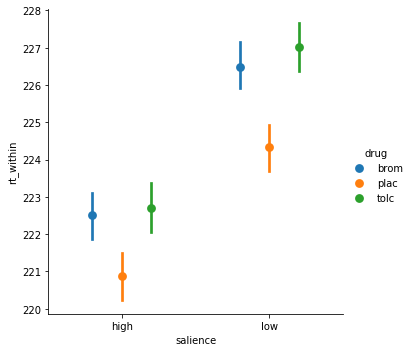

In [77]:
sns.catplot(x = 'salience',
               y = 'rt_within',
               unit = 'sub',
                hue = 'drug',
                join = False,
              dodge = .4,
                ci = 68,
            kind = 'point',
               data = df)

In [78]:
df_model = df.dropna(subset = ['rt']).reset_index()
                             
md = smf.mixedlm("rt ~ C(drug,  Treatment(reference='plac'))*C(salience,Sum)",
                 df_model, groups=df_model['sub']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Mixed Linear Model Regression Results
===================================================================================================================
Model:                               MixedLM                    Dependent Variable:                    rt          
No. Observations:                    28980                      Method:                                REML        
No. Groups:                          77                         Scale:                                 1932.4922   
Min. group size:                     250                        Log-Likelihood:                        -150927.0398
Max. group size:                     639                        Converged:                             Yes         
Mean group size:                     376.4                                                                         
-------------------------------------------------------------------------------------------------------------------
                                                                       Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                                             222.309    2.467 90.108 0.000 217.473 227.145
C(drug, Treatment(reference='plac'))[T.brom]                            1.974    0.636  3.105 0.002   0.728   3.220
C(drug, Treatment(reference='plac'))[T.tolc]                            2.224    0.648  3.435 0.001   0.955   3.494
C(salience, Sum)[S.high]                                               -1.750    0.435 -4.018 0.000  -2.603  -0.896
C(drug, Treatment(reference='plac'))[T.brom]:C(salience, Sum)[S.high]  -0.229    0.622 -0.368 0.713  -1.449   0.991
C(drug, Treatment(reference='plac'))[T.tolc]:C(salience, Sum)[S.high]  -0.391    0.636 -0.616 0.538  -1.638   0.855
Group Var                                                             453.447    1.696                             
===================================================================================================================

"""

### Salience effect by gene<a name="saliencertgene"></a> 

Only significant effect is a DRD2 by salience interaction on placebo (A1- have bigger effect)

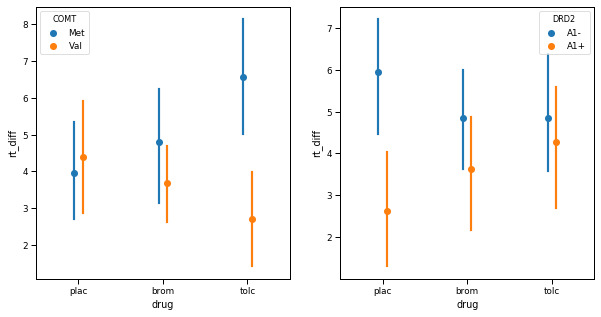

In [92]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
for n, gene in enumerate(['COMT','DRD2']):
    sns.pointplot(y = 'rt_diff',
                 x = 'drug',
                  order = ['plac','brom','tolc'],
                hue = gene,
                ci = 68,
                join = False,
                  dodge = .1,
                unit = 'sub',
                 data = results,
                  ax = ax[n])
plt.savefig('./figs/salience_effect.png', dpi = 300)

In [85]:
df_model = df.dropna(subset = ['rt'])

md = smf.mixedlm("rt ~ C(drug,  Treatment(reference='plac'))*C(salience,Sum)*C(DRD2,Sum)", df_model, groups=df_model['sub']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                 Mixed Linear Model Regression Results
=======================================================================================================================================
Model:                                       MixedLM                          Dependent Variable:                          rt          
No. Observations:                            28980                            Method:                                      REML        
No. Groups:                                  77                               Scale:                                       1932.2102   
Min. group size:                             250                              Log-Likelihood:                              -150919.2027
Max. group size:                             639                              Converged:                                   Yes         
Mean group size:                             376.4                                                                                     
---------------------------------------------------------------------------------------------------------------------------------------
                                                                                           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                 222.412    2.481 89.654 0.000 217.550 227.274
C(drug, Treatment(reference='plac'))[T.brom]                                                1.947    0.636  3.059 0.002   0.699   3.194
C(drug, Treatment(reference='plac'))[T.tolc]                                                2.233    0.648  3.444 0.001   0.962   3.503
C(salience, Sum)[S.high]                                                                   -1.882    0.439 -4.292 0.000  -2.742  -1.023
C(DRD2, Sum)[S.A1+]                                                                        -1.451    2.481 -0.585 0.559  -6.313   3.411
C(drug, Treatment(reference='plac'))[T.brom]:C(salience, Sum)[S.high]                      -0.098    0.625 -0.157 0.875  -1.322   1.126
C(drug, Treatment(reference='plac'))[T.tolc]:C(salience, Sum)[S.high]                      -0.266    0.638 -0.417 0.677  -1.517   0.985
C(drug, Treatment(reference='plac'))[T.brom]:C(DRD2, Sum)[S.A1+]                            0.486    0.636  0.764 0.445  -0.761   1.733
C(drug, Treatment(reference='plac'))[T.tolc]:C(DRD2, Sum)[S.A1+]                           -0.527    0.648 -0.813 0.416  -1.798   0.744
C(salience, Sum)[S.high]:C(DRD2, Sum)[S.A1+]                                                1.105    0.439  2.521 0.012   0.246   1.965
C(drug, Treatment(reference='plac'))[T.brom]:C(salience, Sum)[S.high]:C(DRD2, Sum)[S.A1+]  -0.792    0.625 -1.268 0.205  -2.016   0.432
C(drug, Treatment(reference='plac'))[T.tolc]:C(salience, Sum)[S.high]:C(DRD2, Sum)[S.A1+]  -0.959    0.638 -1.503 0.133  -2.210   0.292
Group Var                                                                                 456.611    1.718                             
=======================================================================================================================================

"""

In [86]:
df_model = df.dropna(subset = ['rt'])

md = smf.mixedlm("rt ~ C(drug,  Treatment(reference='plac'))*C(salience,Sum)*C(COMT,Sum)", df_model, groups=df_model['sub']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                 Mixed Linear Model Regression Results
=======================================================================================================================================
Model:                                       MixedLM                          Dependent Variable:                          rt          
No. Observations:                            28980                            Method:                                      REML        
No. Groups:                                  77                               Scale:                                       1928.3212   
Min. group size:                             250                              Log-Likelihood:                              -150889.2532
Max. group size:                             639                              Converged:                                   Yes         
Mean group size:                             376.4                                                                                     
---------------------------------------------------------------------------------------------------------------------------------------
                                                                                           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                 222.527    2.450 90.824 0.000 217.724 227.329
C(drug, Treatment(reference='plac'))[T.brom]                                                1.702    0.636  2.675 0.007   0.455   2.949
C(drug, Treatment(reference='plac'))[T.tolc]                                                2.249    0.647  3.474 0.001   0.980   3.518
C(salience, Sum)[S.high]                                                                   -1.751    0.435 -4.024 0.000  -2.604  -0.898
C(COMT, Sum)[S.Met]                                                                         4.687    2.450  1.913 0.056  -0.115   9.489
C(drug, Treatment(reference='plac'))[T.brom]:C(salience, Sum)[S.high]                      -0.259    0.623 -0.416 0.678  -1.481   0.963
C(drug, Treatment(reference='plac'))[T.tolc]:C(salience, Sum)[S.high]                      -0.424    0.636 -0.667 0.505  -1.670   0.822
C(drug, Treatment(reference='plac'))[T.brom]:C(COMT, Sum)[S.Met]                           -3.769    0.636 -5.923 0.000  -5.016  -2.522
C(drug, Treatment(reference='plac'))[T.tolc]:C(COMT, Sum)[S.Met]                            1.134    0.647  1.752 0.080  -0.135   2.403
C(salience, Sum)[S.high]:C(COMT, Sum)[S.Met]                                                0.001    0.435  0.003 0.998  -0.852   0.854
C(drug, Treatment(reference='plac'))[T.brom]:C(salience, Sum)[S.high]:C(COMT, Sum)[S.Met]  -0.262    0.623 -0.421 0.674  -1.484   0.959
C(drug, Treatment(reference='plac'))[T.tolc]:C(salience, Sum)[S.high]:C(COMT, Sum)[S.Met]  -0.903    0.636 -1.421 0.155  -2.149   0.343
Group Var                                                                                 446.317    1.681                             
=======================================================================================================================================

"""

### Salience effect by PET <a name="saliencertpet"></a> 

Weak amygdala racliopride by salience effect (stronger salience effect for more amygdala D2/D3). No drug interactions.

Weak tolcapone X dorsal caudate FMT interaction (more DCA synthesis -> weaker salience effect).

Weak ventral striatum by dopamine synthesis effect (more dopamine synthesis -> stronger salience effect). Trending interaction with tolcapone (more dopamine synthesis -> less salience effect on tolcapone)


In [149]:
df_model = df.dropna(subset = ['rt','DCA_fmt'])


pet_measures = ['DCA_rac','VST_rac','AMY_rac','DCA_fmt','VST_fmt']
for pet in pet_measures:
    
    df_model[pet] = scipy.stats.zscore(df_model[pet])
    
    md = smf.mixedlm("rt ~ C(salience,Sum)*C(drug,  Treatment(reference='plac'))*" + pet, 
                     df_model, groups=df_model['sub']).fit()
    print(pet)
    print(md.summary())
    print('\n\n\n')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


DCA_rac
                                           Mixed Linear Model Regression Results
Model:                                   MixedLM                      Dependent Variable:                      rt          
No. Observations:                        19435                        Method:                                  REML        
No. Groups:                              52                           Scale:                                   2045.5457   
Min. group size:                         250                          Log-Likelihood:                          -101763.1686
Max. group size:                         617                          Converged:                               Yes         
Mean group size:                         373.8                                                                             
---------------------------------------------------------------------------------------------------------------------------
                                           

DCA_fmt
                                           Mixed Linear Model Regression Results
Model:                                   MixedLM                      Dependent Variable:                      rt          
No. Observations:                        19435                        Method:                                  REML        
No. Groups:                              52                           Scale:                                   2046.5709   
Min. group size:                         250                          Log-Likelihood:                          -101766.9846
Max. group size:                         617                          Converged:                               Yes         
Mean group size:                         373.8                                                                             
---------------------------------------------------------------------------------------------------------------------------
                                           

Text(0.5, 1, 'Ventral Striatal Adapative Salience Effect')

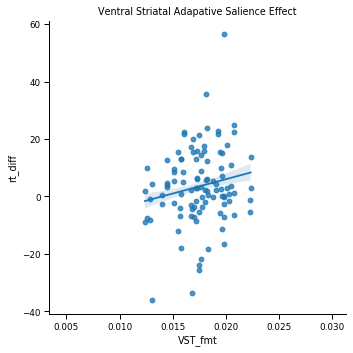

In [105]:
#Placebo effect
r = results[results.drug =='plac']
sns.lmplot(x = 'VST_fmt',
           y = 'rt_diff',
            col = 'drug',
#            y_partial='VST_rac',
           ci = 68,
           data = r)
plt.title('Ventral Striatal Adapative Salience Effect')

Text(0.5, 1, 'Amygdala D2/D3 effect')

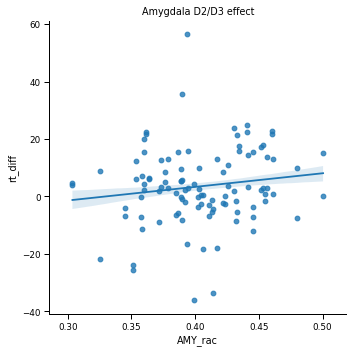

In [106]:
#Placebo effect
r = results[results.drug =='plac']
sns.lmplot(x = 'AMY_rac',
           y = 'rt_diff',
            col = 'drug',
#            y_partial='VST_rac',
           ci = 68,
           data = r)
plt.title('Amygdala D2/D3 effect')

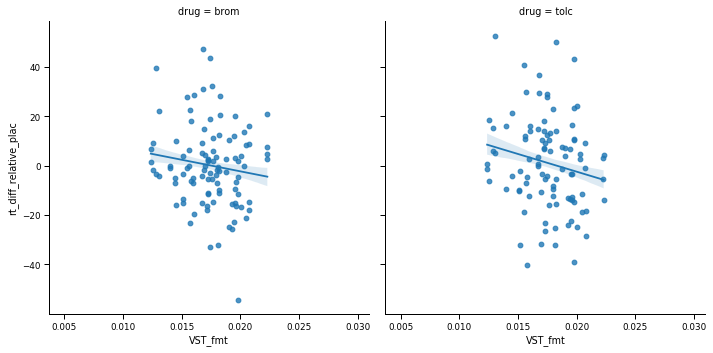

In [152]:
#Plot PET effects as a difference in salience on drug versus placebo
r = results.groupby(['sub','drug','block','DRD2','COMT']).mean().reset_index().set_index(['sub','drug','block'])
for sub, drug,block in set(r.index):
    r.loc[(sub, drug,block), 'rt_diff_relative_plac'] = r.loc[(sub, drug,block), 'rt_diff'] - r.loc[(sub, 
                                                                            'plac',block), 'rt_diff']
    r.loc[(sub, drug,block), 'guess_diff_relative_plac'] = r.loc[(sub, drug,block), 'guess_diff'] - r.loc[(sub, 
                                                                            'plac',block), 'guess_diff']
r = r.reset_index()
r = r[r.drug !='plac']

sns.lmplot(x = 'VST_fmt',
           y = 'rt_diff_relative_plac',
            col = 'drug',
#            y_partial='VST_rac',
           ci = 68,
           data = r)
# plt.savefig('./figs/rt_VST.png', dpi = 300)

## Salience attribution explicit reports <a name="salienceguess"></a>

Both drugs reduce salience effect. No main effect of guessing on RTs

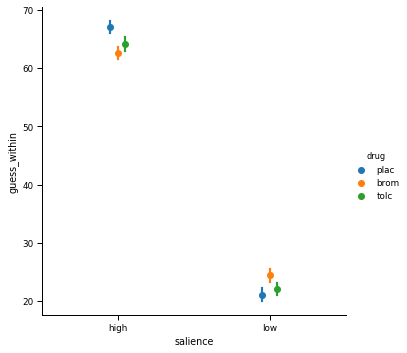

In [121]:
guess_df = df.groupby(['sub','drug','COMT','DRD2','stimulus','salience','block']).mean().reset_index()

sns.catplot(x = 'salience',
             y = 'guess_within',
              hue = 'drug',
            hue_order = ['plac','brom','tolc'],
             unit = 'sub',
            kind = 'point',
            ci = 68,
#             col = 'DRD2',
            dodge = .1,
              join = False,
             data = fig_df)
plt.savefig('./figs/salience_guess.png', dpi = 300)

In [123]:
md = smf.mixedlm("guess ~ C(salience,Sum)*C(drug,Treatment(reference = 'plac'))",
                 guess_df, 
                 groups=guess_df['sub']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Mixed Linear Model Regression Results
================================================================================================================
Model:                                MixedLM                   Dependent Variable:                   guess     
No. Observations:                     1808                      Method:                               REML      
No. Groups:                           77                        Scale:                                293.1930  
Min. group size:                      16                        Log-Likelihood:                       -7728.5174
Max. group size:                      24                        Converged:                            Yes       
Mean group size:                      23.5                                                                      
----------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                                             44.073    0.843 52.277 0.000 42.421 45.725
C(salience, Sum)[S.high]                                              23.000    0.690 33.338 0.000 21.648 24.352
C(drug, Treatment(reference='plac'))[T.brom]                          -0.597    0.980 -0.609 0.542 -2.517  1.323
C(drug, Treatment(reference='plac'))[T.tolc]                          -1.052    0.992 -1.060 0.289 -2.997  0.893
C(salience, Sum)[S.high]:C(drug, Treatment(reference='plac'))[T.brom] -3.919    0.979 -4.004 0.000 -5.838 -2.001
C(salience, Sum)[S.high]:C(drug, Treatment(reference='plac'))[T.tolc] -1.964    0.989 -1.986 0.047 -3.902 -0.026
Group Var                                                             18.079    0.295                           
================================================================================================================

"""

### Salience effect by gene<a name="salienceguessgene"></a> 

Trending tolcapone by COMT crossover interaction; no other effects

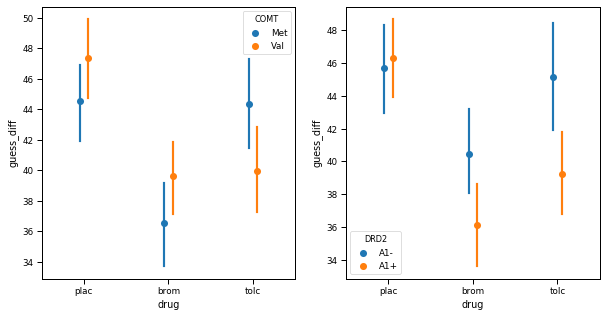

In [153]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
for n, gene in enumerate(['COMT','DRD2']):
    sns.pointplot(y = 'guess_diff',
                 x = 'drug',
                  order = ['plac','brom','tolc'],
                hue = gene,
                ci = 68,
                join = False,
                  dodge = .1,
                unit = 'sub',
                 data = results,
                  ax = ax[n])
plt.savefig('./figs/guess_salience_effect.png', dpi = 300)

In [154]:
md = smf.mixedlm("guess ~ C(DRD2,Sum)*C(salience,Sum)*C(drug,Treatment(reference = 'plac'))",
                 guess_df, 
                 groups=guess_df['sub']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                               Mixed Linear Model Regression Results
====================================================================================================================================
Model:                                      MixedLM                          Dependent Variable:                          guess     
No. Observations:                           1808                             Method:                                      REML      
No. Groups:                                 77                               Scale:                                       292.7611  
Min. group size:                            16                               Log-Likelihood:                              -7720.7025
Max. group size:                            24                               Converged:                                   Yes       
Mean group size:                            23.5                                                                                    
------------------------------------------------------------------------------------------------------------------------------------
                                                                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                 44.129    0.846 52.145 0.000 42.470 45.788
C(DRD2, Sum)[S.A1+]                                                                       -0.864    0.846 -1.021 0.307 -2.523  0.795
C(salience, Sum)[S.high]                                                                  22.990    0.691 33.278 0.000 21.636 24.344
C(drug, Treatment(reference='plac'))[T.brom]                                              -0.630    0.981 -0.643 0.520 -2.552  1.292
C(drug, Treatment(reference='plac'))[T.tolc]                                              -1.098    0.993 -1.106 0.269 -3.044  0.848
C(DRD2, Sum)[S.A1+]:C(salience, Sum)[S.high]                                               0.150    0.691  0.217 0.828 -1.204  1.504
C(DRD2, Sum)[S.A1+]:C(drug, Treatment(reference='plac'))[T.brom]                           0.495    0.981  0.504 0.614 -1.427  2.417
C(DRD2, Sum)[S.A1+]:C(drug, Treatment(reference='plac'))[T.tolc]                           0.787    0.993  0.793 0.428 -1.159  2.733
C(salience, Sum)[S.high]:C(drug, Treatment(reference='plac'))[T.brom]                     -3.852    0.980 -3.931 0.000 -5.773 -1.932
C(salience, Sum)[S.high]:C(drug, Treatment(reference='plac'))[T.tolc]                     -1.894    0.990 -1.913 0.056 -3.833  0.046
C(DRD2, Sum)[S.A1+]:C(salience, Sum)[S.high]:C(drug, Treatment(reference='plac'))[T.brom] -1.241    0.980 -1.267 0.205 -3.162  0.679
C(DRD2, Sum)[S.A1+]:C(salience, Sum)[S.high]:C(drug, Treatment(reference='plac'))[T.tolc] -1.628    0.990 -1.645 0.100 -3.568  0.311
Group Var                                                                                 18.318    0.300                           
====================================================================================================================================

"""

In [155]:
md = smf.mixedlm("guess ~ C(COMT,Sum)*C(salience,Sum)*C(drug,Treatment(reference = 'plac'))",
                 guess_df, 
                 groups=guess_df['sub']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                               Mixed Linear Model Regression Results
====================================================================================================================================
Model:                                      MixedLM                          Dependent Variable:                          guess     
No. Observations:                           1808                             Method:                                      REML      
No. Groups:                                 77                               Scale:                                       293.1242  
Min. group size:                            16                               Log-Likelihood:                              -7721.7078
Max. group size:                            24                               Converged:                                   Yes       
Mean group size:                            23.5                                                                                    
------------------------------------------------------------------------------------------------------------------------------------
                                                                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                 44.074    0.845 52.161 0.000 42.418 45.730
C(COMT, Sum)[S.Met]                                                                        0.019    0.845  0.023 0.982 -1.637  1.675
C(salience, Sum)[S.high]                                                                  22.972    0.690 33.276 0.000 21.619 24.325
C(drug, Treatment(reference='plac'))[T.brom]                                              -0.643    0.981 -0.655 0.512 -2.565  1.279
C(drug, Treatment(reference='plac'))[T.tolc]                                              -1.069    0.993 -1.077 0.282 -3.015  0.877
C(COMT, Sum)[S.Met]:C(salience, Sum)[S.high]                                              -0.714    0.690 -1.034 0.301 -2.067  0.639
C(COMT, Sum)[S.Met]:C(drug, Treatment(reference='plac'))[T.brom]                          -0.907    0.981 -0.925 0.355 -2.829  1.015
C(COMT, Sum)[S.Met]:C(drug, Treatment(reference='plac'))[T.tolc]                          -0.432    0.993 -0.435 0.663 -2.378  1.514
C(salience, Sum)[S.high]:C(drug, Treatment(reference='plac'))[T.brom]                     -3.932    0.980 -4.013 0.000 -5.853 -2.012
C(salience, Sum)[S.high]:C(drug, Treatment(reference='plac'))[T.tolc]                     -1.891    0.990 -1.911 0.056 -3.831  0.048
C(COMT, Sum)[S.Met]:C(salience, Sum)[S.high]:C(drug, Treatment(reference='plac'))[T.brom] -0.059    0.980 -0.060 0.952 -1.979  1.862
C(COMT, Sum)[S.Met]:C(salience, Sum)[S.high]:C(drug, Treatment(reference='plac'))[T.tolc]  1.808    0.990  1.827 0.068 -0.132  3.747
Group Var                                                                                 18.250    0.299                           
====================================================================================================================================

"""

### Salience effect by PET <a name="salienceguesspet"></a> 

Ventral striatal dopamine synthesis interacts with the salience effect (more synthesis -> greater effect)

Ventral striatal dopamine synthesis has interaction with bromo and tolcapone on salience effect (more synthesis -> weaker salience effect on drug) (same pattern but trending in dorsal caudate)

Note: ignoring salience, there is no simple effect of PET on guesses, nor interaction

In [156]:
df_model = guess_df.copy().dropna(subset = ['VST_rac'])
pet_measures = ['DCA_rac','VST_rac','AMY_rac','DCA_fmt','VST_fmt']
for pet in pet_measures:
    
    df_model[pet] = scipy.stats.zscore(df_model[pet])
    
    md = smf.mixedlm("guess ~ C(salience, Sum)*C(drug,  Treatment(reference='plac'))*" + pet, 
                     df_model, 
                     groups=df_model['sub']).fit()
    print(pet)
    print(md.summary())
    print('\n\n\n')

DCA_rac
                                         Mixed Linear Model Regression Results
Model:                                  MixedLM                      Dependent Variable:                      guess     
No. Observations:                       1216                         Method:                                  REML      
No. Groups:                             52                           Scale:                                   288.9194  
Min. group size:                        16                           Log-Likelihood:                          -5180.3120
Max. group size:                        24                           Converged:                               Yes       
Mean group size:                        23.4                                                                            
------------------------------------------------------------------------------------------------------------------------
                                                                  

VST_fmt
                                         Mixed Linear Model Regression Results
Model:                                  MixedLM                      Dependent Variable:                      guess     
No. Observations:                       1216                         Method:                                  REML      
No. Groups:                             52                           Scale:                                   286.5967  
Min. group size:                        16                           Log-Likelihood:                          -5175.1388
Max. group size:                        24                           Converged:                               Yes       
Mean group size:                        23.4                                                                            
------------------------------------------------------------------------------------------------------------------------
                                                                  

Text(0.5, 1, 'Ventral Striatal Adapative Salience Effect')

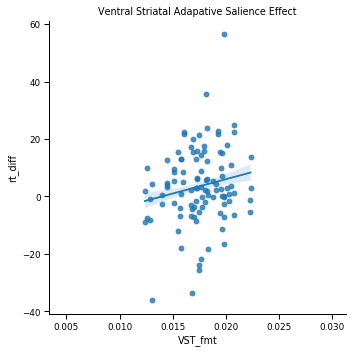

In [157]:
#Placebo effect
r = results[results.drug =='plac']
sns.lmplot(x = 'VST_fmt',
           y = 'rt_diff',
            col = 'drug',
#            y_partial='VST_rac',
           ci = 68,
           data = r)
plt.title('Ventral Striatal Adapative Salience Effect')

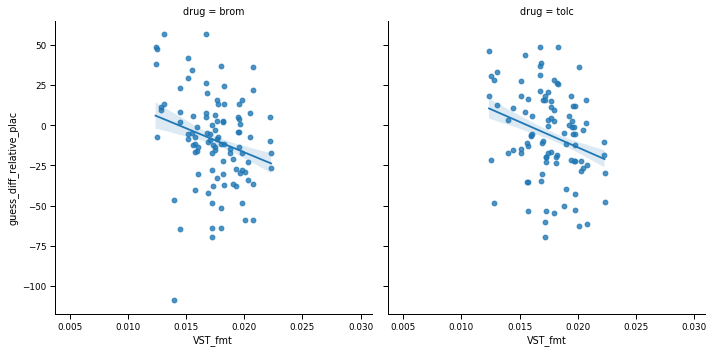

In [158]:
#Plot PET effects as a difference in salience on drug versus placebo
r = results.groupby(['sub','drug','block','DRD2','COMT']).mean().reset_index().set_index(['sub','drug','block'])
for sub, drug,block in set(r.index):
    r.loc[(sub, drug,block), 'rt_diff_relative_plac'] = r.loc[(sub, drug,block), 'rt_diff'] - r.loc[(sub, 
                                                                            'plac',block), 'rt_diff']
    r.loc[(sub, drug,block), 'guess_diff_relative_plac'] = r.loc[(sub, drug,block), 'guess_diff'] - r.loc[(sub, 
                                                                            'plac',block), 'guess_diff']
r = r.reset_index()
r = r[r.drug !='plac']

sns.lmplot(x = 'VST_fmt',
           y = 'guess_diff_relative_plac',
            col = 'drug',
#            y_partial='VST_rac',
           ci = 68,
           data = r)


# Model-free evidence for trial-by-trial learning  <a name="modelfree"></a> 

After a reward, subjects are faster if the same stimulus repeats relative to if there is a new stimulus, with intermediate responding for a difference stimulus the shares a feature. The reverse pattern exists after a negative feedback. These results are consistent with trial-by-trial incremental learning of the stimulus value. Except: RL would predict that all of the blue dots (trials after a rewarded trial) should be lower than the orange onces, reaction times should on average be faster after a reward. We see the opposite main effect, perhaps because cognitive processing of the reward interferes with preparation for the next trial, or perhaps reward omissions act as a cue to respond more quickly.

Both bromocriptine and tolcapone reduce the interaction between whether a trial was rewarded on the last trial and the stimulus type on the last trial.

Trending effect of Amygdala D2/D3 on the interaction between stimulus type and reward on the last trial. 

Amygdala D2/D3 also interacts with post-reward slowing that also interacts with bromocriptine. More slowing for more Amygdala D2/3 (or, more speeding after omission!). This relationship is abolished on bromocriptine.


No DRD2 or COMT interactions with key effect

Trending COMT interaction with the post-reward slowing effect (Mets show more post reward slowing). But no drug interactions.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


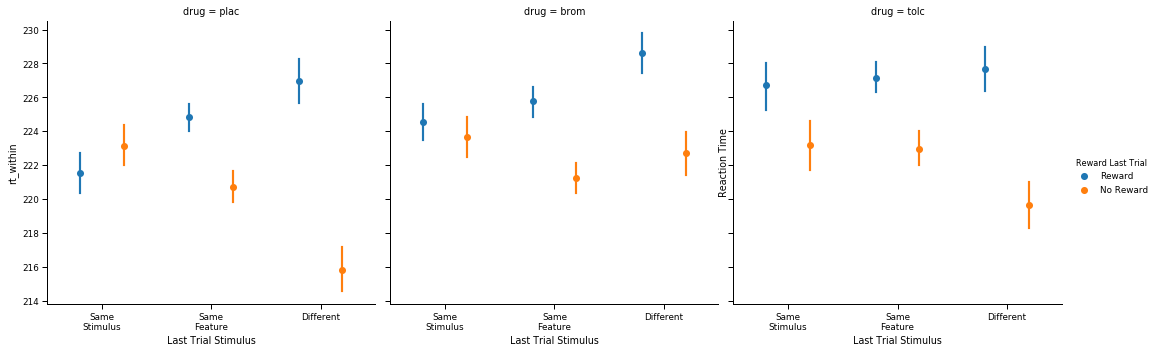

In [160]:
fig_df = df.dropna(subset = ['transition_type'])
label_map = {'SameStim':'Same\nStimulus', 'SameFeature': 'Same\nFeature', 'Different':'Different'}
fig_df['Last Trial Stimulus'] =  [label_map[x] for x in fig_df['transition_type']]

label_map = {0:'No Reward', 1: 'Reward'}
fig_df['Reward Last Trial'] = [label_map[x] for x in fig_df['rew_last_trial_bin']]

sns.catplot(y = 'rt_within',
             x = 'Last Trial Stimulus',
             hue = 'Reward Last Trial',
             unit = 'sub',
            col_order = ['plac','brom','tolc'],
            order = ['Same\nStimulus','Same\nFeature','Different'],
             ci = 68,
             join = False,
              dodge = .4,
#             row = 'DRD2',
            kind = 'point',
            col = 'drug',
             data = fig_df)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Reaction Time')
plt.savefig('./figs/reward_effecs.svg', dpi = 300)

In [161]:
# df_model = df.dropna(subset = ['rt','R_VST_mean_fmt','R_VST_mean_rac'])
df_model = df.dropna(subset = ['rt','rew_last_trial_bin','transition_type'])

transition_map = {'SameFeature':0, 'SameStim':1, 'Different':-1}
df_model['transition_type_bin'] = [transition_map[x] for x in df_model['transition_type']]

md = smf.mixedlm("rt ~C(drug,  Treatment(reference='plac'))*rew_last_trial_bin*transition_type_bin", 
                 df_model, groups=df_model['sub']).fit()
md.summary()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                              Mixed Linear Model Regression Results
=================================================================================================================================
Model:                                     MixedLM                        Dependent Variable:                        rt          
No. Observations:                          28552                          Method:                                    REML        
No. Groups:                                77                             Scale:                                     1926.0586   
Min. group size:                           246                            Log-Likelihood:                            -148642.5657
Max. group size:                           635                            Converged:                                 Yes         
Mean group size:                           370.8                                                                                 
---------------------------------------------------------------------------------------------------------------------------------
                                                                                     Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                           219.776    2.511 87.527 0.000 214.855 224.698
C(drug, Treatment(reference='plac'))[T.brom]                                          2.191    0.899  2.438 0.015   0.429   3.952
C(drug, Treatment(reference='plac'))[T.tolc]                                          2.087    0.917  2.276 0.023   0.290   3.884
rew_last_trial_bin                                                                    4.428    0.877  5.047 0.000   2.709   6.148
C(drug, Treatment(reference='plac'))[T.brom]:rew_last_trial_bin                      -0.442    1.254 -0.353 0.724  -2.899   2.015
C(drug, Treatment(reference='plac'))[T.tolc]:rew_last_trial_bin                       0.543    1.280  0.424 0.672  -1.966   3.052
transition_type_bin                                                                   3.619    0.874  4.140 0.000   1.906   5.332
C(drug, Treatment(reference='plac'))[T.brom]:transition_type_bin                     -3.078    1.256 -2.451 0.014  -5.539  -0.616
C(drug, Treatment(reference='plac'))[T.tolc]:transition_type_bin                     -1.961    1.282 -1.530 0.126  -4.473   0.551
rew_last_trial_bin:transition_type_bin                                               -6.320    1.227 -5.151 0.000  -8.725  -3.915
C(drug, Treatment(reference='plac'))[T.brom]:rew_last_trial_bin:transition_type_bin   3.743    1.750  2.138 0.032   0.312   7.174
C(drug, Treatment(reference='plac'))[T.tolc]:rew_last_trial_bin:transition_type_bin   4.135    1.807  2.288 0.022   0.593   7.677
Group Var                                                                           455.039    1.705                             
=================================================================================================================================

"""

In [183]:
# # df_model = df.dropna(subset = ['rt','R_VST_mean_fmt','R_VST_mean_rac'])
# df_model = df.dropna(subset = ['rt','rew_last_trial_bin','transition_type'])

# transition_map = {'SameFeature':0, 'SameStim':1, 'Different':-1}
# df_model['transition_type_bin'] = [transition_map[x] for x in df_model['transition_type']]

# md = smf.mixedlm("rt ~C(COMT,Sum)*C(drug,  Treatment(reference='plac'))*rew_last_trial_bin*transition_type_bin", 
#                  df_model, groups=df_model['sub']).fit()
# md.summary()
print('#No DRD2 or COMT effects')

#No DRD2 or COMT effects


In [185]:
df_model = df.dropna(subset = ['rt','rew_last_trial_bin','transition_type'])

transition_map = {'SameFeature':0, 'SameStim':1, 'Different':-1}
df_model['transition_type_bin'] = [transition_map[x] for x in df_model['transition_type']]

df_model = df_model.dropna(subset = ['AMY_rac'])

pet_measures = ['AMY_rac']
for pet in pet_measures:
    
    df_model[pet] = scipy.stats.zscore(df_model[pet])


    md = smf.mixedlm("rt ~  rew_last_trial_bin*C(drug,  Treatment(reference='plac'))*transition_type_bin*" + pet, 
                 df_model, 
                     groups=df_model['sub']).fit()

    print(pet)
    print(md.summary())
    print('\n\n\n')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


AMY_rac
                                                  Mixed Linear Model Regression Results
Model:                                       MixedLM                           Dependent Variable:                           rt          
No. Observations:                            19148                             Method:                                       REML        
No. Groups:                                  52                                Scale:                                        2030.9700   
Min. group size:                             246                               Log-Likelihood:                               -100171.7725
Max. group size:                             614                               Converged:                                    Yes         
Mean group size:                             368.2                                                                                       
----------------------------------------------------------------------------

## Bromocriptine impairs learning from omissions  <a name="bromoomissions"></a> 


Bromocriptine appears to slectively flatten learning from reward omissions. When we look just at trials following reward omission, we indeed see a selective effect of bromocriptine, and we see no such effect when looking at losses.

No interactions with COMT/DRD2, nor PET

In [169]:
#Just reward omissions
df_model = df.dropna(subset = ['rt','rew_last_trial_bin','transition_type'])

transition_map = {'SameFeature':0, 'SameStim':1, 'Different':-1}
df_model['transition_type_bin'] = [transition_map[x] for x in df_model['transition_type']]

df_model = df_model[df_model.rew_last_trial_bin == 0]


md = smf.mixedlm("rt ~  C(drug,  Treatment(reference='plac'))*transition_type_bin", 
                 df_model, groups=df_model['sub']).fit()
md.summary()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2114: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/stat

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                    Mixed Linear Model Regression Results
==============================================================================================================
Model:                               MixedLM                  Dependent Variable:                  rt         
No. Observations:                    14178                    Method:                              REML       
No. Groups:                          77                       Scale:                               2031.9895  
Min. group size:                     121                      Log-Likelihood:                      -74237.9861
Max. group size:                     316                      Converged:                           No         
Mean group size:                     184.1                                                                    
--------------------------------------------------------------------------------------------------------------
                                                                  Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                                        219.613    2.226 98.668 0.000 215.250 223.975
C(drug, Treatment(reference='plac'))[T.brom]                       2.309    0.932  2.477 0.013   0.482   4.136
C(drug, Treatment(reference='plac'))[T.tolc]                       2.275    0.950  2.395 0.017   0.413   4.138
transition_type_bin                                                3.433    0.906  3.792 0.000   1.659   5.208
C(drug, Treatment(reference='plac'))[T.brom]:transition_type_bin  -3.170    1.302 -2.434 0.015  -5.722  -0.617
C(drug, Treatment(reference='plac'))[T.tolc]:transition_type_bin  -1.860    1.323 -1.406 0.160  -4.453   0.732
Group Var                                                        348.709    1.060                             
==============================================================================================================

"""

In [182]:
#no interactions with PET
#Just reward omissions
df_model = df.dropna(subset = ['rt','rew_last_trial_bin','transition_type'])

transition_map = {'SameFeature':0, 'SameStim':1, 'Different':-1}
df_model['transition_type_bin'] = [transition_map[x] for x in df_model['transition_type']]

df_model = df_model[df_model.rew_last_trial_bin == 0]

df_model = df_model.dropna(subset = ['AMY_rac'])

pet_measures = ['DCA_rac','VST_rac','AMY_rac','DCA_fmt','VST_fmt']
for pet in pet_measures:
    
    df_model[pet] = scipy.stats.zscore(df_model[pet])


    md = smf.mixedlm("rt ~  C(drug,  Treatment(reference='plac'))*transition_type_bin*" + pet, 
                 df_model, 
                     groups=df_model['sub']).fit()

    print(pet)
    print(md.summary())
    print('\n\n\n')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


DCA_rac
                                        Mixed Linear Model Regression Results
Model:                                 MixedLM                     Dependent Variable:                     rt         
No. Observations:                      9505                        Method:                                 REML       
No. Groups:                            52                          Scale:                                  2166.3402  
Min. group size:                       121                         Log-Likelihood:                         -50069.3583
Max. group size:                       310                         Converged:                              Yes        
Mean group size:                       182.8                                                                          
----------------------------------------------------------------------------------------------------------------------
                                                                          Coef.  

DCA_fmt
                                        Mixed Linear Model Regression Results
Model:                                 MixedLM                     Dependent Variable:                     rt         
No. Observations:                      9505                        Method:                                 REML       
No. Groups:                            52                          Scale:                                  2167.0390  
Min. group size:                       121                         Log-Likelihood:                         -50069.5704
Max. group size:                       310                         Converged:                              Yes        
Mean group size:                       182.8                                                                          
----------------------------------------------------------------------------------------------------------------------
                                                                          Coef.  

## Bromocriptine shifts gain/omission influence on guesses  <a name="bromoomissionsguess"></a> 

There is also evidence for reduced sensitivity to losses on the guess data. First of all, bromocriptine reduces the effect of salience, consistent with a reduced sensitivity to both losses and gains. But, if you remove the variance that can be explained by the difference in outcomes between the high and low salience stimuli, you observe that both high and low salience sitmuli are slightly overestimated to the same extent on placebo. However, on bromocriptine, low salience stimuli are overestimated in value relative to high salience stimuli. The main difference between these stimuli is the number of negative/positive outcomes. This suggests that bromocriptine reduces the sensitivity to losses relative to gains. This effect is mediated by ventral striatal dopamine

43.0

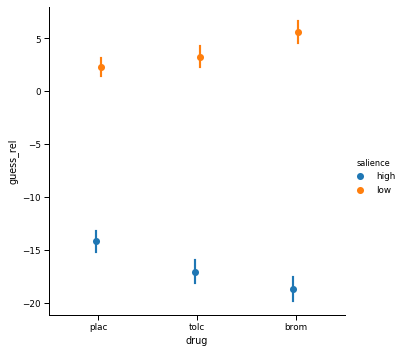

In [231]:
#This plot shows the guesses relative to the true reward probabilities (81.25/81.75). It shows that
#high salience estimates are slightly above the true value, but close relative to low salience estimates,
#which are far below the true value. The median guess is 43, when the true median reward rate is 50
df['no_rew_or_too_slow'] = [x <= .02 for x in df['rew']]
guess_df = df.groupby(['sub','drug','COMT','DRD2','stimulus','salience','block']).mean().reset_index()
guess_df['guess_rel'] = np.NaN
guess_df.loc[guess_df.salience == 'high','guess_rel'] = guess_df.loc[guess_df.salience == 'high','guess'] - 81.25
guess_df.loc[guess_df.salience == 'low','guess_rel'] = guess_df.loc[guess_df.salience == 'low','guess'] - 18.75

sns.catplot(x = 'drug',
             y = 'guess_rel',
              hue = 'salience',
              ci = 68,
              join = False,
            order = ['plac','tolc','brom'],
            dodge = .05,
            kind = 'point',
             data = guess_df)
np.median(df['guess'])

In [232]:
#The above pattern could hold if subjects do not code the .02 rewards as true rewards, given the feedback "Too Slow!"
#This is the reward rate when counting .02 as omission
df['rew_bin'] = df['rew'] > 0.02
df.groupby(['stimulus']).mean()['rew_bin']

stimulus
A1_B1    0.591489
A1_B2    0.587633
A2_B1    0.129255
A2_B2    0.134574
Name: rew_bin, dtype: float64

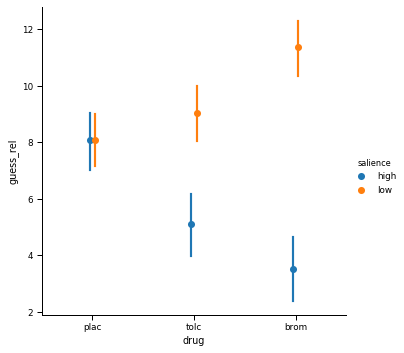

In [274]:
#Coding in this way eliminates the salience difference on placebo, both high and low salience stims are slightly
#overestimated. Notice also that bromocriptine causes a salience difference where low salience is overestimated 
#relative to high salience. This could occur if bromocriptine reduces the weight of reward omissions, which are
#much more common in the low salience stimuli

# avg_rew_rate = guess_df.groupby(['sub','drug','block','salience']).mean()
# guess_df = guess_df.set_index(['sub','drug','block','stimulus'])
# for sub, drug, block, stimulus in set(guess_df.index):
#     if stimulus in ['A1_B1','A1_B2']:
#         salience = 'high'
#     else:
#         salience = 'low'
#     guess_df.loc[(sub,drug,block,stimulus),'guess_rel'] = guess_df.loc[(sub,drug,block,stimulus),'guess'] - 100*(1 - avg_rew_rate.loc[(sub,drug,block,salience),'no_rew_or_too_slow'])

# guess_df = guess_df.reset_index()


guess_df.loc[guess_df.salience == 'high','guess_rel'] = guess_df.loc[guess_df.salience == 'high','guess'] - 59
guess_df.loc[guess_df.salience == 'low','guess_rel'] = guess_df.loc[guess_df.salience == 'low','guess'] - 13

sns.catplot(x = 'drug',
             y = 'guess_rel',
              hue = 'salience',
              ci = 68,
              join = False,
            order = ['plac','tolc','brom'],
            dodge = .05,
            kind = 'point',
             data = guess_df)

In [263]:
#Indeed, bromocriptine selective reduces the effect of reward-versus-omissions on guesses
md = smf.mixedlm("guess_rel ~ no_rew_or_too_slow*C(drug,Treatment(reference = 'plac'))",
                 guess_df, 

                 groups=guess_df['sub']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Mixed Linear Model Regression Results
===========================================================================================================
Model:                             MixedLM                  Dependent Variable:                  guess_rel 
No. Observations:                  1808                     Method:                              REML      
No. Groups:                        77                       Scale:                               295.3072  
Min. group size:                   16                       Log-Likelihood:                      -7730.3264
Max. group size:                   24                       Converged:                           Yes       
Mean group size:                   23.5                                                                    
-----------------------------------------------------------------------------------------------------------
                                                                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                                        7.789    1.938  4.020 0.000   3.991 11.587
C(drug, Treatment(reference='plac'))[T.brom]                    -8.867    2.639 -3.360 0.001 -14.040 -3.694
C(drug, Treatment(reference='plac'))[T.tolc]                    -3.972    2.718 -1.461 0.144  -9.300  1.356
no_rew_or_too_slow                                               0.442    2.716  0.163 0.871  -4.882  5.767
no_rew_or_too_slow:C(drug, Treatment(reference='plac'))[T.brom] 12.988    3.830  3.391 0.001   5.482 20.494
no_rew_or_too_slow:C(drug, Treatment(reference='plac'))[T.tolc]  4.558    3.933  1.159 0.246  -3.150 12.266
Group Var                                                       17.769    0.292                            
===========================================================================================================

"""

In [264]:
##No DRD2 effect, weak COMT X tolcapone effect
md = smf.mixedlm("guess_rel ~ C(COMT,Sum)*no_rew_or_too_slow*C(drug,Treatment(reference = 'plac'))",
                 guess_df, 

                 groups=guess_df['sub']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                             Mixed Linear Model Regression Results
===============================================================================================================================
Model:                                     MixedLM                        Dependent Variable:                        guess_rel 
No. Observations:                          1808                           Method:                                    REML      
No. Groups:                                77                             Scale:                                     294.8779  
Min. group size:                           16                             Log-Likelihood:                            -7718.1067
Max. group size:                           24                             Converged:                                 Yes       
Mean group size:                           23.5                                                                                
-------------------------------------------------------------------------------------------------------------------------------
                                                                                    Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                            7.704    1.939  3.973 0.000   3.903 11.505
C(COMT, Sum)[S.Met]                                                                 -1.713    1.939 -0.883 0.377  -5.513  2.088
C(drug, Treatment(reference='plac'))[T.brom]                                        -9.229    2.648 -3.485 0.000 -14.420 -4.039
C(drug, Treatment(reference='plac'))[T.tolc]                                        -3.642    2.723 -1.338 0.181  -8.978  1.694
C(COMT, Sum)[S.Met]:C(drug, Treatment(reference='plac'))[T.brom]                    -2.292    2.649 -0.865 0.387  -7.483  2.899
C(COMT, Sum)[S.Met]:C(drug, Treatment(reference='plac'))[T.tolc]                     4.431    2.721  1.628 0.103  -0.903  9.765
no_rew_or_too_slow                                                                   0.571    2.718  0.210 0.834  -4.757  5.899
C(COMT, Sum)[S.Met]:no_rew_or_too_slow                                               2.695    2.718  0.992 0.321  -2.632  8.022
no_rew_or_too_slow:C(drug, Treatment(reference='plac'))[T.brom]                     13.408    3.840  3.491 0.000   5.881 20.935
no_rew_or_too_slow:C(drug, Treatment(reference='plac'))[T.tolc]                      4.027    3.939  1.022 0.307  -3.694 11.748
C(COMT, Sum)[S.Met]:no_rew_or_too_slow:C(drug, Treatment(reference='plac'))[T.brom]  1.985    3.841  0.517 0.605  -5.543  9.512
C(COMT, Sum)[S.Met]:no_rew_or_too_slow:C(drug, Treatment(reference='plac'))[T.tolc] -7.574    3.938 -1.923 0.054 -15.292  0.144
Group Var                                                                           17.775    0.294                            
===============================================================================================================================

"""

In [265]:
#Interaction with ventral striatal dopamine synthesis capacity, and also interaction with both pet measures
mod_df = guess_df.dropna(subset = ['DCA_rac'])
for pet in pet_measures:
    
    mod_df[pet] = scipy.stats.zscore(mod_df[pet])
    
    md = smf.mixedlm("guess_rel ~ no_rew_or_too_slow*C(drug,Treatment(reference = 'plac'))*" + pet, 
                     mod_df, groups=mod_df['sub']).fit()
    print(pet)
    print(md.summary())
    print('\n\n\n')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


DCA_rac
                                       Mixed Linear Model Regression Results
Model:                                MixedLM                     Dependent Variable:                     guess_rel 
No. Observations:                     1216                        Method:                                 REML      
No. Groups:                           52                          Scale:                                  290.9875  
Min. group size:                      16                          Log-Likelihood:                         -5175.4560
Max. group size:                      24                          Converged:                              Yes       
Mean group size:                      23.4                                                                          
--------------------------------------------------------------------------------------------------------------------
                                                                         Coef.  Std.Err.   z    

VST_fmt
                                       Mixed Linear Model Regression Results
Model:                                MixedLM                     Dependent Variable:                     guess_rel 
No. Observations:                     1216                        Method:                                 REML      
No. Groups:                           52                          Scale:                                  290.1317  
Min. group size:                      16                          Log-Likelihood:                         -5173.6277
Max. group size:                      24                          Converged:                              Yes       
Mean group size:                      23.4                                                                          
--------------------------------------------------------------------------------------------------------------------
                                                                         Coef.  Std.Err.   z    

# RT variability influenced by tolcapone  <a name="rtvariability"></a> 

RT variability is a proxy for executive function.  A1- have lower RT variability at baseline but no interaction with drug. COMT Met/Vals have the same variability at baseline, but tolcapone helps the vals (reduced rt variability) and impairs the mets, consistent with the inverted-U. 

No PET effects on placebo, but some weak interactions with drugs: 
    -Reduced RT variability on tolcapone for higher dorsal caudate raclopride
    -Reduced RT variability on tolcapone for higher ventral striatal raclopride
    -Reduced RT variability on bromocriptine for higher dorsal caudate dopamine synthesis capacity
    -Reduced RT variability on bromocriptine and tolcapone for higher ventral striatal dopamine synthesis capacity

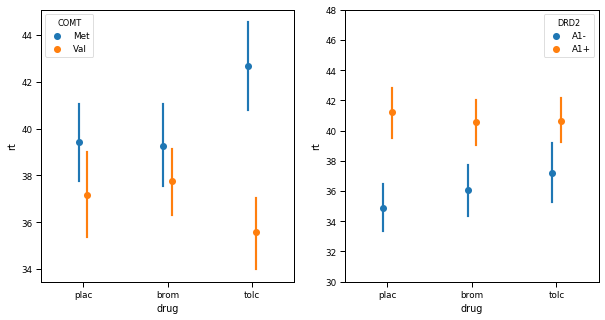

In [284]:
df_std = df.groupby(['sub','drug','block','COMT','DRD2']).std().reset_index()
cols = [c for c in df_std.columns if 'rac' not in c]
cols = [c for c in cols if 'fmt' not in c]
df_std=df_std[cols]
df_std = pd.merge(pet_df,df_std, how = 'outer', on = ['sub'])

fig, ax = plt.subplots(1,2, figsize = (10,5))
for n, gene in enumerate(['COMT','DRD2']):
    sns.pointplot(y = 'rt',
                 x = 'drug',
           order = ['plac','brom','tolc'],
                hue = gene,
                ci = 68,
                join = False,
                  dodge = .1,
                unit = 'sub',
                 data = df_std,
                  ax = ax[n])
    plt.ylim(30,48)
plt.savefig('./figs/rt_var.svg', dpi = 300)

In [285]:
#Tolcapone X COMT interaction on RT variability
md = smf.mixedlm("rt ~ C(COMT,Sum)*C(drug,Treatment(reference = 'plac'))",
                 df_std, 
                 groups=df_std['sub']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Mixed Linear Model Regression Results
============================================================================================================
Model:                              MixedLM                  Dependent Variable:                  rt        
No. Observations:                   452                      Method:                              REML      
No. Groups:                         77                       Scale:                               104.1189  
Min. group size:                    4                        Log-Likelihood:                      -1758.3134
Max. group size:                    6                        Converged:                           Yes       
Mean group size:                    5.9                                                                     
------------------------------------------------------------------------------------------------------------
                                                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                                         38.287    1.461 26.212 0.000 35.425 41.150
C(COMT, Sum)[S.Met]                                                1.145    1.461  0.784 0.433 -1.718  4.008
C(drug, Treatment(reference='plac'))[T.brom]                       0.170    1.170  0.146 0.884 -2.122  2.463
C(drug, Treatment(reference='plac'))[T.tolc]                       0.888    1.186  0.749 0.454 -1.436  3.213
C(COMT, Sum)[S.Met]:C(drug, Treatment(reference='plac'))[T.brom]  -0.442    1.170 -0.378 0.706 -2.734  1.851
C(COMT, Sum)[S.Met]:C(drug, Treatment(reference='plac'))[T.tolc]   2.276    1.186  1.919 0.055 -0.048  4.601
Group Var                                                        111.979    2.278                           
============================================================================================================

"""

In [286]:
#DRD2 effect on placebo
md = smf.mixedlm("rt ~ C(DRD2,Sum)*C(drug,Treatment(reference = 'plac'))",
                 df_std, 
                 groups=df_std['sub']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Mixed Linear Model Regression Results
============================================================================================================
Model:                              MixedLM                  Dependent Variable:                  rt        
No. Observations:                   452                      Method:                              REML      
No. Groups:                         77                       Scale:                               105.4169  
Min. group size:                    4                        Log-Likelihood:                      -1759.7540
Max. group size:                    6                        Converged:                           Yes       
Mean group size:                    5.9                                                                     
------------------------------------------------------------------------------------------------------------
                                                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                                         38.036    1.451 26.206 0.000 35.192 40.881
C(DRD2, Sum)[S.A1+]                                                3.178    1.451  2.190 0.029  0.334  6.023
C(drug, Treatment(reference='plac'))[T.brom]                       0.268    1.177  0.227 0.820 -2.040  2.575
C(drug, Treatment(reference='plac'))[T.tolc]                       0.867    1.194  0.726 0.468 -1.473  3.207
C(DRD2, Sum)[S.A1+]:C(drug, Treatment(reference='plac'))[T.brom]  -0.960    1.177 -0.815 0.415 -3.268  1.348
C(DRD2, Sum)[S.A1+]:C(drug, Treatment(reference='plac'))[T.tolc]  -1.218    1.194 -1.020 0.308 -3.558  1.122
Group Var                                                        108.824    2.210                           
============================================================================================================

"""

In [288]:
mod_df = df_std.dropna(subset = ['DCA_rac'])
for pet in pet_measures:
    
    mod_df[pet] = scipy.stats.zscore(mod_df[pet])
    
    md = smf.mixedlm("rt ~ C(drug,Treatment(reference = 'plac'))*" + pet, 
                     mod_df, groups=mod_df['sub']).fit()
    print(pet)
    print(md.summary())
    print('\n\n\n')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


DCA_rac
                             Mixed Linear Model Regression Results
Model:                          MixedLM              Dependent Variable:              rt        
No. Observations:               304                  Method:                          REML      
No. Groups:                     52                   Scale:                           109.3985  
Min. group size:                4                    Log-Likelihood:                  -1184.5893
Max. group size:                6                    Converged:                       Yes       
Mean group size:                5.8                                                             
------------------------------------------------------------------------------------------------
                                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------
Intercept                                           